# CV, estimating camera pose

In [4]:
# import homography
# import camera
# import sift
# # compute features
# sift.process_image('book_frontal.JPG','im0.sift')
# l0,d0 = sift.read_features_from_file('im0.sift')
# sift.process_image('book_perspective.JPG','im1.sift')
# l1,d1 = sift.read_features_from_file('im1.sift')
# # match features and estimate homography
# matches = sift.match_twosided(d0,d1)
# ndx = matches.nonzero()[0]
# fp = homography.make_homog(l0[ndx,:2].T)
# ndx2 = [int(matches[i]) for i in ndx]
# tp = homography.make_homog(l1[ndx2,:2].T)
# model = homography.RansacModel()
# H = homography.H_from_ransac(fp,tp,model)

AttributeError: module 'sift' has no attribute 'process_image'

# Camera Calibration

In [ ]:
def my_calibration(sz):
    row,col = sz
    fx = 2555*col/2592
    fy = 2586*row/1936
    K = diag([fx,fy,1])
    K[0,2] = 0.5*col
    K[1,2] = 0.5*row
    return K

# Homography

In [23]:
import cv2
import numpy as np

# Read images
img1 = cv2.imread('book_frontal.JPG', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('book_perspective.JPG', cv2.IMREAD_GRAYSCALE)

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Compute features
keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

# Match features using BFMatcher
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)

# Sort matches by distance
matches = sorted(matches, key=lambda x: x.distance)

# Extract location of good matches
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt

# Compute homography using RANSAC
H, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

print("Homography matrix:")
print(H)

# If you want to visualize the matches
img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
cv2.imshow('Matches', img_matches)
cv2.waitKey(0)
cv2.destroyAllWindows()


Homography matrix:
[[ 2.58590403e-01  1.74583944e-01  1.77651165e+02]
 [-1.66762848e-02  5.76816443e-01  1.67363507e+01]
 [-7.86805964e-04  7.35261231e-04  1.00000000e+00]]


In [8]:
def cube_points(c,wid):
    """ Creates a list of points for plotting
    a cube with plot. (the first 5 points are
    the bottom square, some sides repeated). """
    p = []
    #bottom
    p.append([c[0]-wid,c[1]-wid,c[2]-wid])
    p.append([c[0]-wid,c[1]+wid,c[2]-wid])
    p.append([c[0]+wid,c[1]+wid,c[2]-wid])
    p.append([c[0]+wid,c[1]-wid,c[2]-wid])
    p.append([c[0]-wid,c[1]-wid,c[2]-wid]) #same as first to close plot
    #top
    p.append([c[0]-wid,c[1]-wid,c[2]+wid])
    p.append([c[0]-wid,c[1]+wid,c[2]+wid])
    p.append([c[0]+wid,c[1]+wid,c[2]+wid])
    p.append([c[0]+wid,c[1]-wid,c[2]+wid])
    p.append([c[0]-wid,c[1]-wid,c[2]+wid]) #same as first to close plot
    #vertical sides
    p.append([c[0]-wid,c[1]-wid,c[2]+wid])
    p.append([c[0]-wid,c[1]+wid,c[2]+wid])
    p.append([c[0]-wid,c[1]+wid,c[2]-wid])
    p.append([c[0]+wid,c[1]+wid,c[2]-wid])
    p.append([c[0]+wid,c[1]+wid,c[2]+wid])
    p.append([c[0]+wid,c[1]-wid,c[2]+wid])
    p.append([c[0]+wid,c[1]-wid,c[2]-wid])
    return array(p).T

# camera calibration
K = my_calibration((747,1000))
# 3D points at plane z=0 with sides of length 0.2
box = cube_points([0,0,0.1],0.1)
# project bottom square in first image

cam1 = camera.Camera( hstack((K,dot(K,array([[0],[0],[-1]])) )) )
# first points are the bottom square
box_cam1 = cam1.project(homography.make_homog(box[:,:5]))
# use H to transfer points to the second image
box_trans = homography.normalize(dot(H,box_cam1))
# compute second camera matrix from cam1 and H
cam2 = camera.Camera(dot(H,cam1.P))
A = dot(linalg.inv(K),cam2.P[:,:3])
A = array([A[:,0],A[:,1],cross(A[:,0],A[:,1])]).T
cam2.P[:,:3] = dot(K,A)
# project with the second camera
box_cam2 = cam2.project(homography.make_homog(box))
# test: projecting point on z=0 should give the same
point = array([1,1,0,1]).T
print(homography.normalize(dot(dot(H,cam1.P),point)))
print(cam2.project(point))

NameError: name 'my_calibration' is not defined

In [22]:
from PIL import Image 
import numpy as np 

def shift_image(img, depth_img, shift_amount=10): 
	# Ensure base image has alpha 
	img = img.convert("RGBA") 
	data = np.array(img) 

	# Ensure depth image is grayscale (for single value) 
	depth_img = depth_img.convert("L") 
	depth_data = np.array(depth_img) 
	deltas = ((depth_data / 255.0) * float(shift_amount)).astype(int) 

	# This creates the transparent resulting image. 
	# For now, we're dealing with pixel data. 
	shifted_data = np.zeros_like(data) 

	height, width, _ = data.shape 

	for y, row in enumerate(deltas): 
		for x, dx in enumerate(row): 
			if x + dx < width and x + dx >= 0: 
				shifted_data[y, x + dx] = data[y, x] 

	# Convert the pixel data to an image. 
	shifted_image = Image.fromarray(shifted_data.astype(np.uint8)) 

	return shifted_image 

img = Image.open("cube1.jpeg") 
depth_img = Image.open("cube2.jpeg") 
shifted_img = shift_image(img, depth_img, shift_amount=50) 
shifted_img.show()


# Graph cut segmentation

(183, 275, 3)


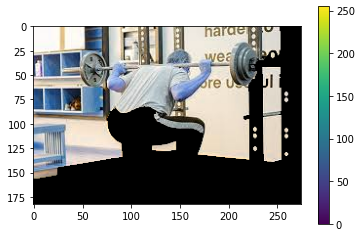

(<matplotlib.image.AxesImage at 0x18e4b8af6d0>,
 None)

In [32]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
img = cv.imread('images/squat2.jpg')
assert img is not None, "file could not be read, check with os.path.exists()"
mask = np.zeros(img.shape[:2],np.uint8)

bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

print(img.shape)
rect = (0,0,274,182)
cv.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img*mask2[:,:,np.newaxis]
plt.imshow(img),plt.colorbar(),plt.show()